# Modelos Compostos

In [73]:
%run ../src/feature_engineering.py
%run ../src/model_evaluation.py
%run ../src/plot.py
%run ../src/pipeline.py

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR,  LinearSVC

%matplotlib inline
#Alterando configurações padrão dos plots
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 60)

In [3]:
course_df = pd.read_csv('../data/preprocessed/edx_2014_train.csv',low_memory=False)
course_df.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,...,course_has_certification,course_subject,course_level,course_language,course_transcript_en,course_transcript_pt,course_transcript_es,course_transcript_de,course_transcript_cn,course_year
0,CB22x,MHxPC130442623,1,0,0,0,United States,NaN,NaN,NaN,...,NaN,History,Introductory,English,False,False,False,False,False,CB22x_2013
1,CS50x,MHxPC130442623,1,1,0,0,United States,NaN,NaN,NaN,...,True,Computer Science,Introductory,English,True,False,False,False,False,CS50x_2012
2,CB22x,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,...,NaN,History,Introductory,English,False,False,False,False,False,CB22x_2013
3,CS50x,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,...,True,Computer Science,Introductory,English,True,False,False,False,False,CS50x_2012
4,ER22x,MHxPC130275857,1,0,0,0,United States,NaN,NaN,NaN,...,False,Humanities,Introductory,English,True,True,True,True,True,ER22x_2013


---

Previsto         0         1         2         3         4         5
Real                                                                
0         0.969344  0.029580  0.000807  0.000269  0.000000  0.000000
1         0.530255  0.444268  0.020701  0.004777  0.000000  0.000000
2         0.215686  0.411765  0.254902  0.117647  0.000000  0.000000
3         0.000000  0.108108  0.135135  0.351351  0.162162  0.243243
4         0.000000  0.000000  0.000000  0.200000  0.400000  0.400000
5         0.000000  0.000000  0.000000  0.163265  0.408163  0.428571
---

Previsto    0    5
Real              
0         1.0  0.0
5         0.0  1.0
---

Previsto         0         1         2         3         4         5
Real                                                                
0         0.970006  0.027091  0.001693  0.001209  0.000000  0.000000
1         0.481250  0.427679  0.063393  0.027679  0.000000  0.000000
2         0.290780  0.326241  0.283688  0.099291  0.000000  0.000000
3         0.

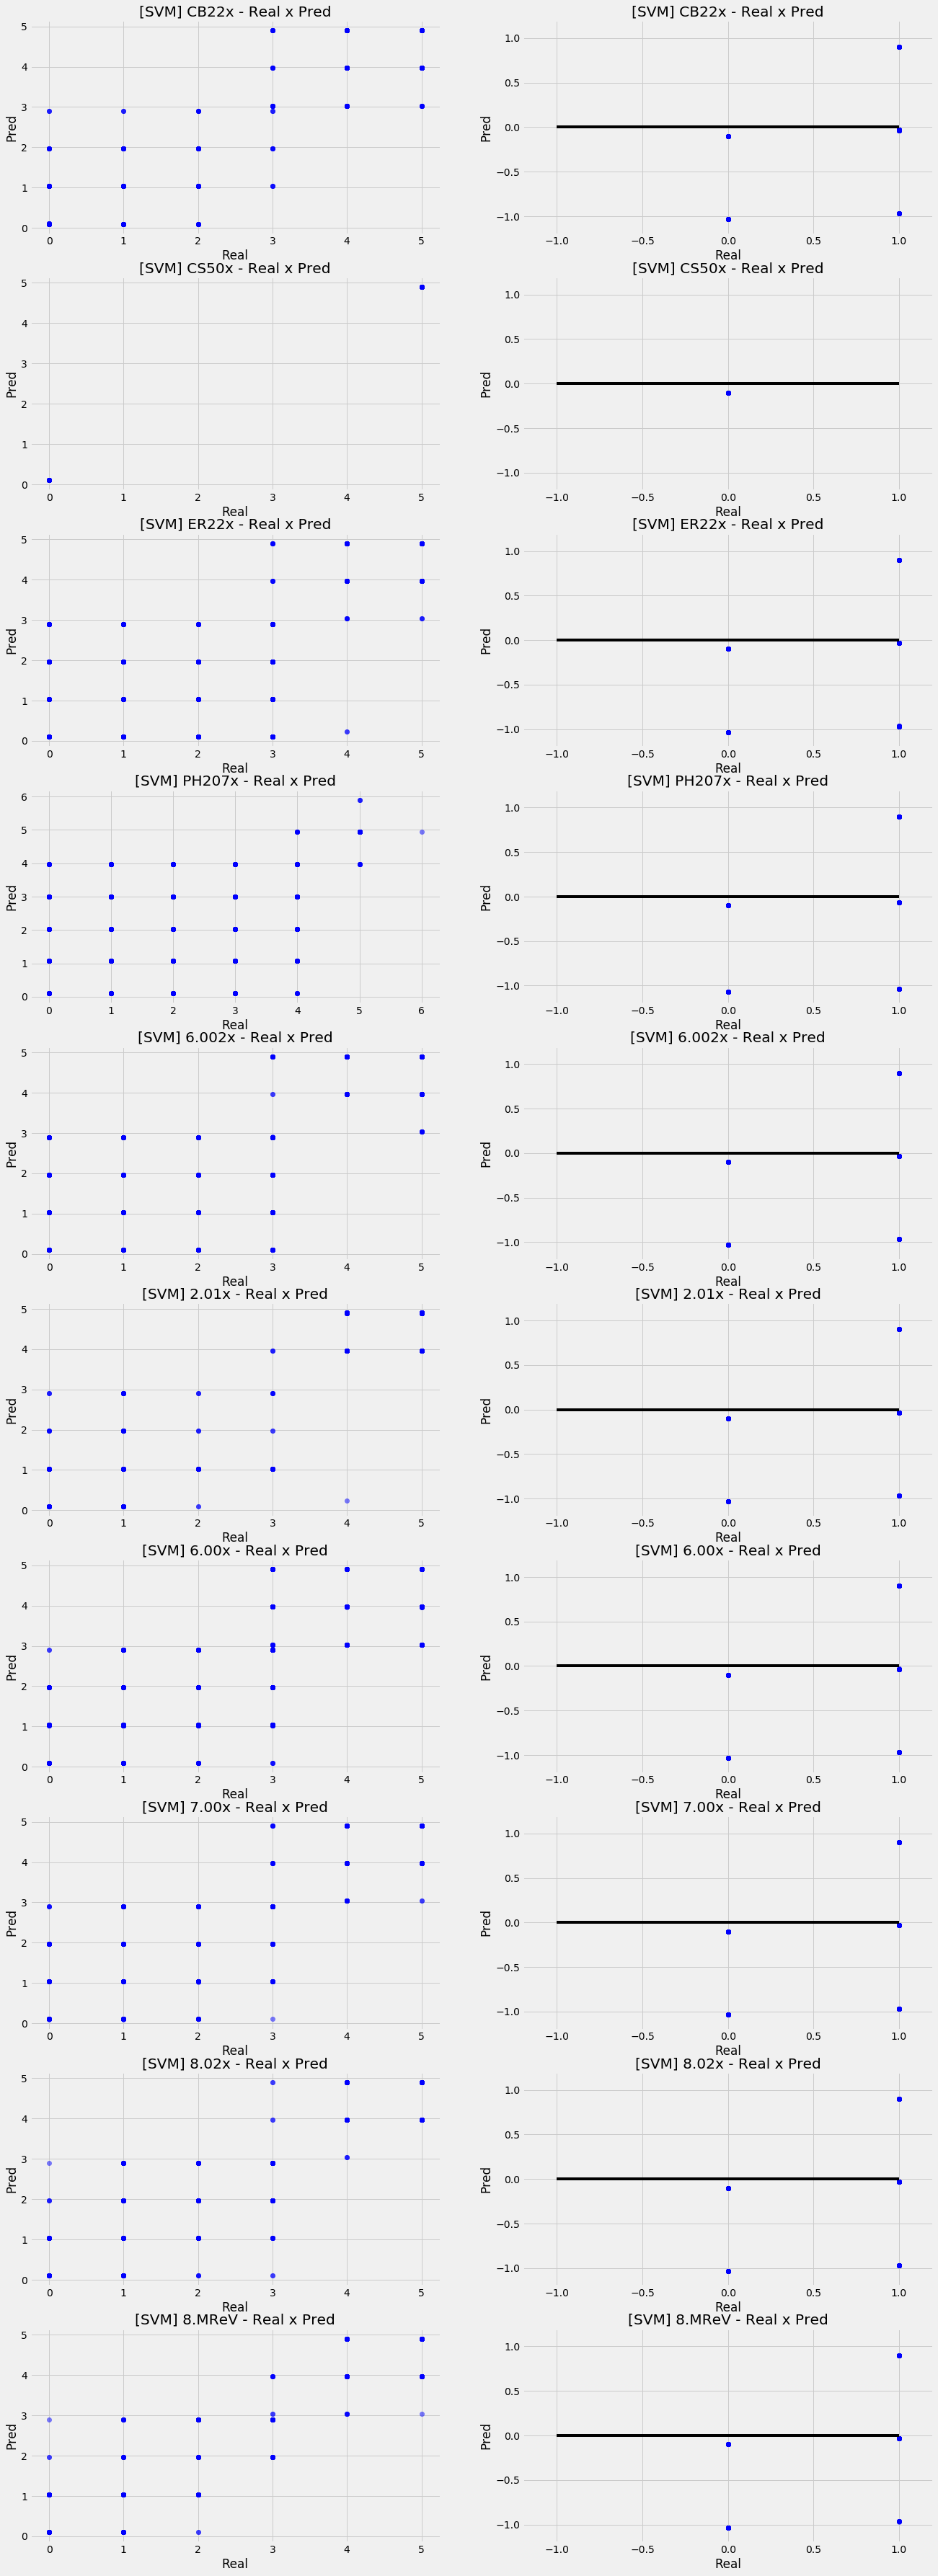

In [76]:
model_providers = ['SVM']
model_name = 'SVM'
m = 0

plots= [scatter_real_vs_pred_subplot, scatter_residual_error_subplot]
results = {'SVM': {}}

course_df['grade'] = course_df['grade'].map(lambda g: g if g > 0 else 0)
courses = course_df['course_id'].unique()
for i, course_id in enumerate(courses):
    course = feature_extract(course_df[course_df['course_id'] == course_id])
    X, y =course.loc[:, course.columns != 'grade'], course['grade'].map(lambda g: math.ceil(g*5) if g >= 0 else -1 )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    pred_test = clf.predict(X_test)
     
    X_train, X_test =  pd.DataFrame(X_train), pd.DataFrame(X_test)    
    X_train['has_grade'] =  clf.predict(X_train)
    X_test['has_grade'] =  clf.predict(X_test)   
    
    print('---\n')
    print(pd.crosstab(y_test, pred_test, rownames=['Real'], colnames=['Previsto']).apply(lambda r: r/r.sum(), axis=1))

    
    model = Pipeline([('scaler', StandardScaler()),
                  ('poly', SVR(kernel='linear'))])
    
    if X_train.shape[0] > 30000:
        X_train = X_train[:30000]
        y_train = y_train[:30000]
    
    model.fit(X_train, y_train)                         
    pred_test = model.predict(X_test)
    results['SVM'][course_id] = regression_evaluation(pred_test, y_test)
                     
    for p, plot in enumerate(plots):
        plt.subplot(len(courses) * len(model_providers), len(plots), len(courses)*m + (len(plots)*i) + p + 1)
        plot(plt, y_test, pred_test, title= '['+model_name+'] '+course_id + " - Real x Pred")                  

plt.show()

In [78]:
reform = {(level2_key, level3_key): values
              for level1_key, level2_dict in results.items()
              for level2_key, level3_dict in level2_dict.items()
              for level3_key, values      in level3_dict.items()}
pd.options.display.float_format = '{:,.4f}'.format
pd.DataFrame(reform, index=['LinearRegression']).T

LinearRegression
2.01x  explained_variance_score            0.8216
       mean_absolute_error                 0.2321
       mean_squared_error                  0.1949
       r2_score                            0.8153
6.002x explained_variance_score            0.8510
       mean_absolute_error                 0.2105
       mean_squared_error                  0.1637
       r2_score                            0.8429
6.00x  explained_variance_score            0.7567
       mean_absolute_error                 0.2150
       mean_squared_error                  0.1509
       r2_score                            0.7446
7.00x  explained_variance_score            0.8243
       mean_absolute_error                 0.2202
       mean_squared_error                  0.1615
       r2_score                            0.8139
8.02x  explained_variance_score            0.8572
       mean_absolute_error                 0.1755
       mean_squared_error                  0.0998
       r2_score                            0.8434
8.MReV explained_variance_score            0.8240
       mean_absolute_error                 0.2043
       mean_squared_error                  0.1348
       r2_score                            0.8123
CB22x  explained_variance_score            0.7362
       mean_absolute_error                 0.1620
       mean_squared_error                  0.0858
       r2_score                            0.7061
CS50x  explained_variance_score            0.9984
       mean_absolute_error                 0.0997
       mean_squared_error                  0.0099
       r2_score                            0.9454
ER22x  explained_variance_score            0.8756
       mean_absolute_error                 0.1796
       mean_squared_error                  0.1199
       r2_score                            0.8665
PH207x explained_variance_score            0.8209
       mean_absolute_error                 0.2513
       mean_squared_error                  0.2446
       r2_score                            0.8136

In [37]:
course = course_df[course_df['course_id'] == '6.00x']
course = feature_extract(course)
X, y = course.loc[:, course.columns != 'grade'], course['grade'].map(lambda g: 1 if g >= 0 else 0 )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

pred_test = clf.predict(X_test)

pd.crosstab(y_test, pred_test, rownames=['Real'], colnames=['Previsto']).apply(lambda r: r/r.sum(), axis=1)


Previsto,0,1
Real,,
0,0.086877,0.913123
1,0.045339,0.954661


In [ ]:



class DecisionTree:
    def provide(self):
        return DecisionTreeRegressor(criterion='mae', max_depth=3)
    

results, plt = train_evaluate([DecisionTree()], course_df, split_criteria='course_id', feature_extractor=feature_extract, 
                              label='grade', evaluation=regression_evaluation, normalize=normalize,
                              plots= [scatter_real_vs_pred_subplot, scatter_residual_error_subplot])

plt.show()